### Notebook for reducing an AuxTel spectrum.
Initially written 03 Feb 2020 by Craig Lage.\
Trying to duplicate Matlab functionality from Chris Stubbs within the DM framework.

In [1]:
! eups list -s | grep lsst_distrib

lsst_distrib          19.0.0+32  	current w_2020_04 setup


In [2]:
import sys, os, glob, time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.interpolate import LSQUnivariateSpline
import astropy.io.fits as pf

from lsst.daf.persistence import Butler
import lsst.afw.image as afwImage
import lsst.afw.table as afwTable
from lsst.ip.isr.isrTask import IsrTask, IsrTaskConfig
from lsst.meas.algorithms import SourceDetectionTask
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask, CharacterizeImageConfig
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Set up data path, isrTask, and source detection
dataPath = '/project/shared/auxTel'
butler = Butler(dataPath)

isrConfig = IsrTask.ConfigClass()
isrConfig.doLinearize = False
isrConfig.doBias = True
isrConfig.doFlat = False
isrConfig.doDark = False
isrConfig.doFringe = False
isrConfig.doDefect = False
isrConfig.doAddDistortionModel = False
isrConfig.doWrite = False
isrConfig.doSaturationInterpolation = False
isrTask = IsrTask(config=isrConfig)

# create the output table for source detection
schema = afwTable.SourceTable.makeMinimalSchema()
config = SourceDetectionTask.ConfigClass()
config.thresholdValue = 100  # detection threshold after smoothing
sourceDetectionTask = SourceDetectionTask(schema=schema, config=config)
table = afwTable.SourceTable.make(schema)

# Routine to sum up the source flux
def sumSourceFlux(source, exp):
    bbox = source.getFootprint().getBBox()
    return np.sum(exp[bbox].image.array)   

# Routine to return the brightest object
def findPeakFlux(sources, exp):
    peak = 0.0
    imax = 0
    for i, source in enumerate(sources):
        flux = sumSourceFlux(source, exp)
        if flux > peak:
            peak = flux
            imax = i
    return imax

AT_O_20200128_000335: Dark time less than exposure time. Setting dark time to the exposure time.


Peak flux object is at (2281.41, 2392.85)


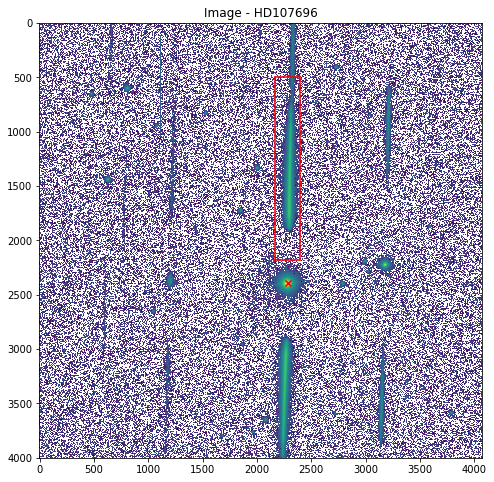

In [4]:
# Now find the location of the brightest object
# and plot it as a double-check

# Image to look at
dataId = {'dayObs':"2020-01-28", 'seqNum':335}

dataRef = butler.dataRef('raw', **dataId)
postIsrExp = isrTask.runDataRef(dataRef).exposure
object = postIsrExp.getMetadata()['OBJECT']
result = sourceDetectionTask.run(table, postIsrExp, sigma=12.1)
peakIndex = findPeakFlux(result.sources, postIsrExp)
xCen = result.sources[peakIndex].getFootprint().getCentroid().x
yCen = result.sources[peakIndex].getFootprint().getCentroid().y
print("Peak flux object is at (%.2f, %.2f)"%(xCen,yCen))
peakBBox = result.sources[peakIndex].getFootprint().getBBox()
figure = plt.figure(figsize = (8,8))
plt.title("Image - %s"%object)
plt.imshow(postIsrExp.image.array, norm=LogNorm(vmin=1.0, vmax=100000))
plt.scatter([xCen],[yCen], marker='x', color='red')

# Define bounding box of spectrum and plot it
specMinX = peakBBox.getMinX(); specMaxX = peakBBox.getMaxX()
specMinY = 500; specMaxY = peakBBox.getMinY() - 100
plt.plot([specMinX, specMaxX], [specMinY, specMinY], color='red')
plt.plot([specMinX, specMaxX], [specMaxY, specMaxY], color='red')
plt.plot([specMinX, specMinX], [specMinY, specMaxY], color='red')
plt.plot([specMaxX, specMaxX], [specMinY, specMaxY], color='red')
plt.savefig("/project/cslage/AuxTel_sky/graphs/Image_%s.png"%object)

In [5]:
rawSpectrum = np.flip(postIsrExp.image.array[specMinY:specMaxY, specMinX:specMaxX].sum(axis=1))
print(rawSpectrum.shape)
# From @stubbs, for image 2020012800335-det000.fits 760 nm is at x=1210 away from star's
# This converts the pixel counts into wavelength
lam = np.flip(np.linspace(yCen-specMinY, yCen-specMaxY, specMaxY - specMinY) / 1210.0 * 760.0)

(1679,)


Text(0, 0.5, 'Total counts(ADU)')

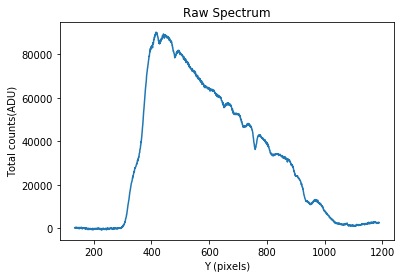

In [6]:
plt.plot(lam, rawSpectrum)
plt.title("Raw Spectrum")
plt.xlabel("Y (pixels)")
plt.ylabel("Total counts(ADU)")

In [7]:
# Following @stubbs, use a spline fit to get absorption spectrum
# The following are unattenuted points on spectrum in nm
splineKnots=[320, 340, 360, 380, 395, 416, 442, 467, 496, 539, 600, 632, 668, 702, 738, 775, 800, 843, 878, \
             888, 907, 971, 1000]
continuum = LSQUnivariateSpline(lam, rawSpectrum, splineKnots)
# Couldn't go as small as 0.5 nm spacing without getting a spline error
evenSpacing = np.linspace(300.0, 1100.0, 1201)
specEvenSpacing = LSQUnivariateSpline(lam, rawSpectrum, evenSpacing)

Text(0, 0.5, 'Total counts(ADU)')

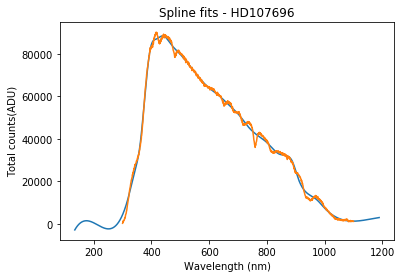

In [8]:
plt.title("Spline fits - %s"%object)
plt.plot(lam, continuum(lam))
plt.plot(evenSpacing, specEvenSpacing(evenSpacing))
plt.xlabel("Wavelength (nm)")
plt.ylabel("Total counts(ADU)")

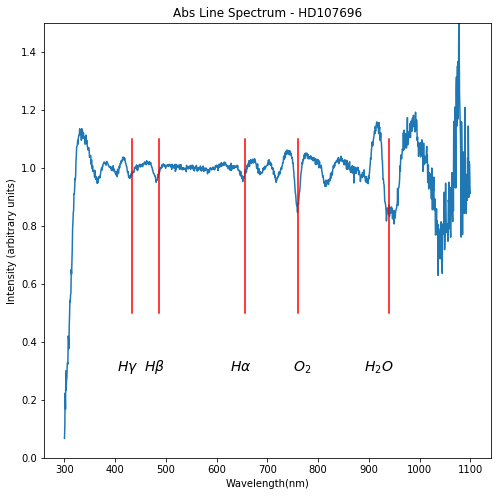

In [9]:
plt.figure(figsize = (8,8))
plt.title("Abs Line Spectrum - %s"%object)
plt.plot(evenSpacing, specEvenSpacing(evenSpacing)/continuum(evenSpacing))
plt.xlabel("Wavelength(nm)")
plt.ylabel("Intensity (arbitrary units)")
plt.ylim(0.0,1.5)
plt.plot([760, 760],[0.5, 1.1],'r-')
plt.text(750,0.3,r'$O_2$', fontsize=14)
plt.plot([656, 656],[0.5, 1.1],'r-')
plt.text(626,0.3,r'$H \alpha $', fontsize=14)
plt.plot([486, 486],[0.5, 1.1],'r-')
plt.text(456,0.3,r'$H \beta$', fontsize=14)
plt.plot([434, 434],[0.5, 1.1],'r-')
plt.text(404,0.3,r'$H \gamma$', fontsize=14)
plt.plot([940, 940],[0.5, 1.1],'r-')
plt.text(890,0.3,r'$H_2O$', fontsize=14)
plt.savefig("/project/cslage/AuxTel_sky/graphs/Spectrum_%s.png"%object)